In [1]:
#!/usr/bin/env python

# Idaelized-double-core_example.ipynb

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm

from tqdm import tqdm

In [2]:
def core_2d_properties(Objects,
                      w_2D,
                      cloudmask,
                      heigt,
                      lentgh):
    # this function calculates properties of 2D cores
    
    gr_core = {}
    for ob in range(len(Objects)):
        gr_core_act = {}

        w_core = np.copy(w_2D[Objects[ob]])
        w_core[rgiObjectsUD[Objects[ob]] != ob+1] = np.nan
        mask_core = w_core > 0
        
        cloudmask_act = cloudmask[Objects[ob]]
        cloudmask_act[np.isnan(w_core)] = 0
        # ignore core if it is partly outside of cloud or touching the boundarie
        if np.sum(~np.isnan(cloudmask_act))/np.sum(np.isnan(cloudmask_act)) < 0.8:
            continue
        
        heigt_core = height[Objects[ob][0]]
        length_core = (lentgh)[Objects[ob][1]]
        if len(heigt_core) <= 3:
            # cores that are less than four cell deep are not assessed
            continue

        dz_core = heigt_core[1:] - heigt_core[:-1]
        dz_core = np.append(dz_core, dz_core[-1])
        
        dx_core = lentgh[1:] - lentgh[:-1]
        dx_core = np.append(dx_core, dx_core[-1])

        # calculate slope of core
        xx = np.array([np.mean(length_core[mask_core[ll]]) for ll in range(len(heigt_core))])
        core_slope = scipy.stats.linregress(heigt_core,xx).slope

        # plt.pcolormesh(length_core, heigt_core, w_core)
        # plt.scatter(xx,heigt_core, c='k')

        # calculate core width
        core_width = np.array([np.sum(dx_core[Objects[ob][1]][mask_core[ll]] ) for ll in range(len(heigt_core))])
        core_with_mean = np.mean(core_width)
        core_with_max = np.max(core_width)

        # core speed
        core_speed_max = np.nanmax(w_core)
        core_speed_mean = np.nanmean(w_core)

        # core depth
        core_height = np.array([np.sum(dz_core[mask_core[:,ll]]) for ll in range(len(length_core))])
        core_height_mean = np.mean(core_height)
        core_heigth_max = np.max(core_height)

        mean_height = np.mean(np.array([np.mean(heigt_core[mask_core[:,ll]]) for ll in range(len(length_core))]))

        gr_core_act['mean elevation'] = mean_height
        gr_core_act['mean depth'] = core_height_mean
        gr_core_act['max depth'] = core_heigth_max
        gr_core_act['mean speed'] = core_speed_mean
        gr_core_act['max speed'] = core_speed_max
        gr_core_act['mean width'] = core_with_mean
        gr_core_act['max width'] = core_with_max
        gr_core_act['slope from vertical'] = core_slope

        gr_core[str(ob+1)] = gr_core_act

    return gr_core

In [3]:
def core_3d_properties(w_3D,
                      rgiObjectsUD,
                      Objects,
                      height,
                      lat_m,
                      lon_m):

    dx = lon_m[1:] - lon_m[:-1]
    dx = np.append(dx, dx[-1])
    dy = lat_m[1:] - lat_m[:-1]
    dy = np.append(dy, dy[-1])
    dxy = np.meshgrid(dx,dy)[0]

    dx_3d = np.repeat(dxy[np.newaxis, :, :], len(height), axis=0)

    dz = height[1:] - height[:-1]
    dz = np.append(dz, dz[-1])
    dz_3d = np.repeat(dz[:,np.newaxis], len(lat_m), axis=1)
    dz_3d = np.repeat(dz_3d[:,:,np.newaxis], len(lon_m), axis=2)

    gr_core = {}
    for ob in range(len(Objects)):
        gr_core_act = {}

        heigt_core = Objects[ob][0].stop - Objects[ob][0].start
        if heigt_core <= 3:
            # cores that are less than four grid cell deep are not assessed
            continue

        core_ouline_act = rgiObjectsUD[Objects[ob]] == (ob+1)
        # plt.pcolormesh(core_ouline_act[10,:,:])

        core_dx = dx_3d[Objects[ob]] * core_ouline_act
        core_dx[core_dx == 0] = np.nan
        width_x = np.nansum(core_dx, axis=1); width_x[width_x == 0] = np.nan
        width_y = np.nansum(core_dx, axis=2); width_y[width_y == 0] = np.nan
        core_mean_width = np.append(width_x, width_y)
        core_mean_width = core_mean_width[~np.isnan(core_mean_width)]
        core_max_width = np.nanmax([np.nanmax(np.nansum(core_dx, axis=1)) , np.nanmax(np.nansum(core_dx, axis=2))])
        

        area_profile = np.nancumsum(np.nansum(core_dx, axis=(1,2)))
        try:
            center_point = np.where(area_profile/np.nanmax(area_profile) > 0.5)[0][0]
        except:
            continue
        core_mean_elevation = height[Objects[ob][0]][center_point]

        core_dz = dz_3d[Objects[ob]] * core_ouline_act
        core_dz[core_dz == 0] = np.nan
        core_mean_depth = np.nanmean(np.nansum(core_dz, axis = 0))
        core_max_depth = np.nanmax(np.nansum(core_dz, axis = 0))

        core_w_act = np.copy(w_3D[Objects[ob]]) * core_ouline_act
        core_w_act[core_w_act == 0] = np.nan
        core_w_act[rgiObjectsUD[Objects[ob]] != (ob+1)] = np.nan
        core_mean_speed = np.nanmean(core_w_act)
        core_max_speed = np.nanmax(core_w_act)

        gr_core_act['mean elevation'] = core_mean_elevation
        gr_core_act['mean depth'] = core_mean_depth
        gr_core_act['max depth'] = core_max_depth
        gr_core_act['mean speed'] = core_mean_speed
        gr_core_act['max speed'] = core_max_speed
        gr_core_act['mean width'] = core_mean_width
        gr_core_act['max width'] = core_max_width

        gr_core[str(ob+1)] = gr_core_act
        
    return gr_core

### SET IDEALIZED CORE PROPERTIES

In [4]:
dx = 100 # m - grid spacing of domain
ilon = 250 # grid cells in logitude direction
ilat = 100 # grid cells in latitude direction
top = 15000  # m - top of domain
dt = 1 # s
itime = 600 # time steps

# cores
radius = np.array([1000,1500])    # radius of drafts
draft_corespeed = np.array([15,20]) # m/s
horizontal_advection = 30 # m/s



### derived settings
ilev = int(top/dx)
start_height = (radius/dx * 1.2).astype('int')
start_lon = (radius/dx * 1.2).astype('int')
start_lat = (np.array([ilat / 2, ilat / 2])).astype('int')

center_heigt_time = np.linspace(start_height, start_height + (draft_corespeed * dt * itime)/dx, itime).astype(int)
center_lon_time = np.linspace(start_lon, start_lon + (horizontal_advection * dt * itime)/dx, itime).astype(int)

# create important matrizes
data = np.zeros((itime, ilev, ilat, ilon))
height = np.linspace(0,top,ilev+1)
lon_m = np.linspace(0,dx*ilon,ilon+1)
lat_m = np.linspace(0,dx*ilat,ilat+1)

length = np.arange(0,itime,dt)[:] * horizontal_advection

# create 3d coordinate arrays
height3D = np.repeat(np.repeat(height[:-1,np.newaxis],ilat, axis=1)[:,:,np.newaxis]  ,ilon, axis=2)
lat = np.repeat(np.repeat(lat_m[np.newaxis,:-1],len(height[:-1]), axis=0)[:,:,np.newaxis]  ,ilon, axis=2)
lon = np.repeat(np.repeat(lon_m[np.newaxis,:-1],ilat, axis=0)[np.newaxis,:,:] ,len(height[:-1]), axis=0)

### create draft in matrix

In [5]:
for co in range(len(radius)):
    for tt in tqdm(range(itime)):
        z_cent = center_heigt_time[tt] * dx 
        lon_cent = center_lon_time[tt] * dx 
        lat_cent = int(ilat / 2) * dx

        distance = ((height3D - z_cent[co])**2 + (lon - lon_cent[co])**2 + (lat - lat_cent)**2)**0.5
        
        norm_dist = np.copy(distance)
        norm_dist[distance >= radius[co]] = np.nan
        norm_dist = (norm_dist - np.nanmin(norm_dist)) / (np.nanmax(norm_dist) - np.nanmin(norm_dist))
        norm_dist = np.abs(norm_dist - 1)
        norm_dist = norm_dist * draft_corespeed[co]

        data[tt, distance < radius[co]] = \
            np.nanmax(np.array([data[tt, distance < radius[co]], norm_dist[distance < radius[co]]]), axis=0)

100%|██████████| 600/600 [01:01<00:00,  9.80it/s]


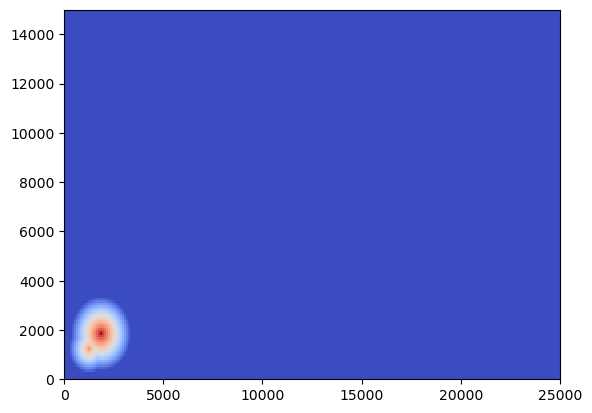

In [6]:
plt.pcolormesh(lon_m, height, data[0,:,50,:], vmin=0, vmax=20, cmap='coolwarm')

### Perform 3D Watershedding

In [31]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy import ndimage

import warnings
warnings.filterwarnings("ignore")

draft_th = 3 # m/s
tt_max = 300
angle_moove = np.linspace(-120, -100, tt_max+1)

import matplotlib.pyplot as plt
import numpy as np
sPlotFile = '/glade/campaign/mmm/c3we/prein/Papers/2023_ConvCores/plot/3D_idealized-cores/'




for tt in [100]: #tqdm(range(tt_max)):
    data_act = np.copy(data[tt,:,:,:])
    image = data_act > draft_th
    objects_id_bt, num_objects = ndimage.label(image, structure=np.ones((3, 3, 3)))



    distance = ndimage.distance_transform_edt(objects_id_bt)
    local_maxi = peak_local_max(
        distance, indices=False, footprint=np.ones((3, 3, 3)), labels=objects_id_bt,
        min_distance=int(1000/dx), threshold_abs=1)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=objects_id_bt)

    num_objects = len(np.unique(labels))-1
    if num_objects > 1:
        size = np.array([np.sum(labels == ii+1) for ii in range(num_objects)])
        color_rank = np.abs(np.argsort(size)-1)
    else:
        color_rank = [0]



#     sPlotName = str(tt).zfill(3)+'_3D-idealized-cores.jpg'

#     fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')

#     colors = ['Reds', 'Blues']
#     for dr in [1,2]:
#         draft_act = np.array(np.where(labels == dr))

#         for ii in range(draft_act.shape[1])[::3]:
#             xs = draft_act[0,ii]/10
#             ys = draft_act[1,ii]/10
#             zs = draft_act[2,ii]/10
#             speed = data_act[draft_act[0,ii], draft_act[1,ii], draft_act[2,ii]]
#             ax.scatter(xs, ys, zs, marker='.', c = speed, cmap=colors[color_rank[dr-1]], alpha=0.1,
#                       vmin = 3, vmax=20)

#     ax.set_xlabel('longitude [km]')
#     ax.set_ylabel('latitude [km]')
#     ax.set_zlabel('heigth [km]')

#     ax.set_xlim([0,10])
#     ax.set_ylim([0,10])
#     ax.set_zlim([0,10])


#     elev = 20
#     azim = angle_moove[tt]
#     roll = 0
#     ax.view_init(elev, azim, roll)

#     plt.title('3D updraft identification '+str(tt)+' s after start')

#     # fig.savefig(sPlotFile+sPlotName, dpi=200)
#     plt.show()


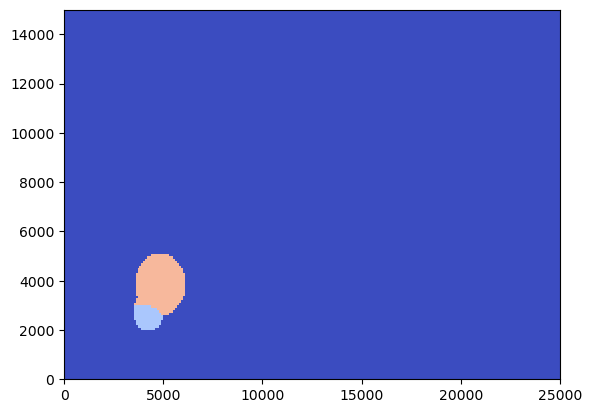

In [32]:
plt.pcolormesh(lon_m[::supsamp], height[::supsamp], labels[:,int(50/supsamp),:], vmin=0, vmax=3, cmap='coolwarm')

In [128]:
def watersheding(label_matrix,  # 2D or 3D matrix with labeled objects [np.array]
                   min_dist,      # minimum distance between two objects [int]
                   threshold):    # minimum threshold difference between two objects [int]
    
    import numpy as np
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    
    if len(label_matrix.shape()) == 2:
        conection = np.ones((3, 3))
    elif len(label_matrix.shape()) == 3:
        conection = np.ones((3, 3, 3))       
    
    distance = ndimage.distance_transform_edt(label_matrix)
    local_maxi = peak_local_max(
        distance, indices=False, footprint=np.ones((3, 3, 3)), labels=label_matrix,
        min_distance=min_dist, threshold_abs=threshold)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=label_matrix)
    
    return labels

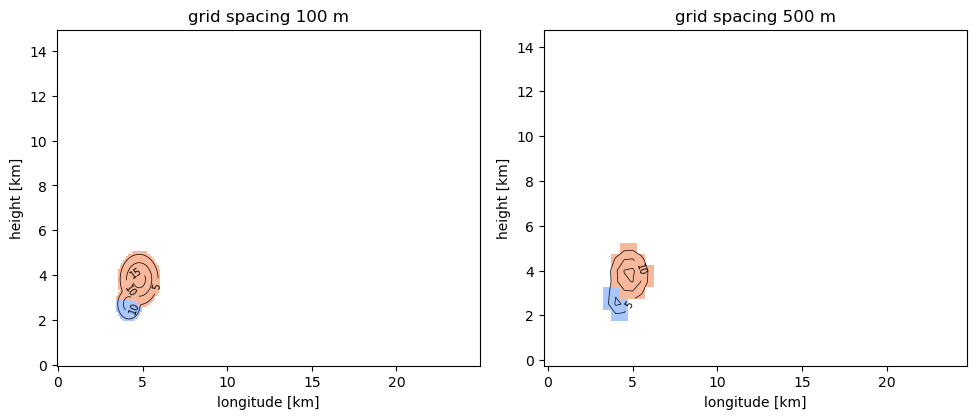

In [129]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy import ndimage

import warnings
warnings.filterwarnings("ignore")

draft_th = 3 # m/s
tt_max = 300
angle_moove = np.linspace(-120, -100, tt_max+1)

import matplotlib.pyplot as plt
import numpy as np
sPlotFile = '/glade/campaign/mmm/c3we/prein/Papers/2023_ConvCores/plot/2D_vis_3D-cores/'



color_dr = ['#e41a1c','#377eb8']
for tt in [100]: #tqdm(range(tt_max)):
    
    fig = plt.figure(figsize=(10,4))
    # Histogram plots
    gs1 = gridspec.GridSpec(1,2) 
    gs1.update(left=0.06, right=0.97,
               bottom=0.13, top=0.97,
               wspace=0.15, hspace=0.1)
    
    resolution = [1, 5]
    grid_spacing = ['100 m', '500 m']
    sPlotName = str(tt).zfill(3)+'_2D_of_3D-idealized-cores.jpg'
    for re in range(len(resolution)):
        ax = plt.subplot(gs1[0,re])
        supsamp = resolution[re]
        data_act = np.copy(data[tt,::supsamp,::supsamp,::supsamp])
        image = data_act > draft_th
        objects_id_bt, num_objects = ndimage.label(image, structure=np.ones((3, 3, 3)))

        
        labels = watersheding3d(objects_id_bt,
                                int(1000/(dx*supsamp)),
                                1)
        
        # distance = ndimage.distance_transform_edt(objects_id_bt)
        # local_maxi = peak_local_max(
        #     distance, indices=False, footprint=np.ones((3, 3, 3)), labels=objects_id_bt,
        #     min_distance=int(1000/(dx*supsamp)), threshold_abs=1)
        # markers = ndimage.label(local_maxi)[0]
        # labels = watershed(-distance, markers, mask=objects_id_bt)


        labels = np.array(labels, dtype='float')
        labels[labels == 0] = np.nan

        plt.pcolormesh(lon_m[:-1][::supsamp]/1000, height[:-1][::supsamp]/1000., labels[:,int(50/supsamp),:], 
                       vmin=0, vmax=3, cmap='coolwarm')
        CS = plt.contour(lon_m[:-1][::supsamp]/1000, height[:-1][::supsamp]/1000., data_act[:,int(50/supsamp),:], 
                       levels = [5,10,15,20,25], colors='k',linewidths = 0.5, )
        plt.clabel(CS, inline=1, fontsize=7)

        ax.set_xlabel('longitude [km]')
        ax.set_ylabel('height [km]')
        plt.title('grid spacing ' + grid_spacing[re])
        
    fig.savefig(sPlotFile+sPlotName, dpi=200, bbox_inches='tight')


In [114]:
sPlotFile+sPlotName

'/glade/campaign/mmm/c3we/prein/Papers/2023_ConvCores/plot/2D_vis_3D-cores000_2D_of_3D-idealized-cores.jpg'

In [112]:
sPlotName

'063_2D_of_3D-idealized-cores.jpg'

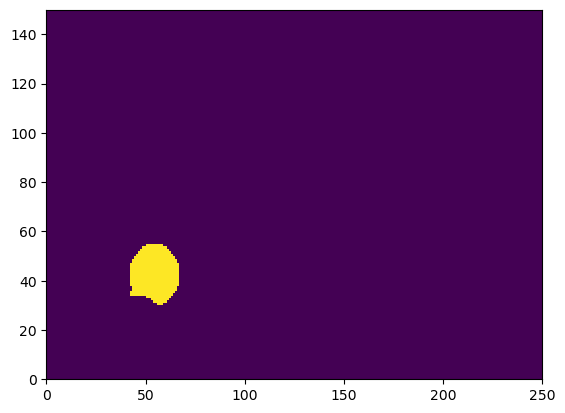

In [74]:
plt.pcolormesh(labels[:,int(50/supsamp),:]==2)

In [87]:
labels

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [50]:
labels.shape

(150, 100, 250)

In [58]:
### Coarsen the data and repeat the watersheding
supsamp = 5
data_act = np.copy(data[tt,::supsamp,::supsamp,::supsamp])

image = data_act > draft_th
objects_id_bt, num_objects = ndimage.label(image, structure=np.ones((3, 3, 3)))


distance = ndimage.distance_transform_edt(objects_id_bt)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((3, 3, 3)), labels=objects_id_bt,
    min_distance=int(1000/(dx*supsamp)), threshold_abs=1)
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=objects_id_bt)

In [14]:
int(1000/(dx*supsamp))

10

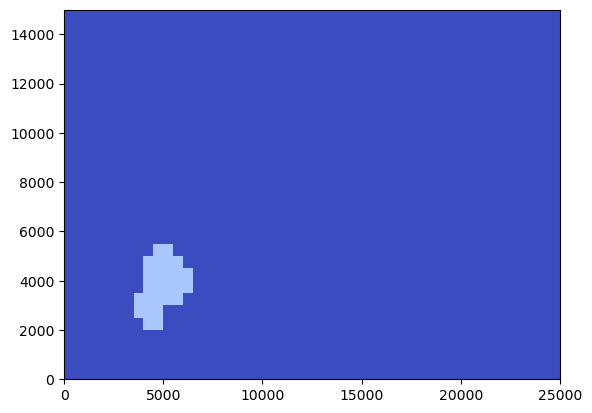

In [51]:
plt.pcolormesh(lon_m[::supsamp], height[::supsamp], objects_id_bt[:,int(50/supsamp),:], vmin=0, vmax=3, cmap='coolwarm')

In [50]:
objects_id_bt.min()

0

In [30]:
data[tt,::supsamp,::supsamp,::supsamp].shape

(30, 20, 50)

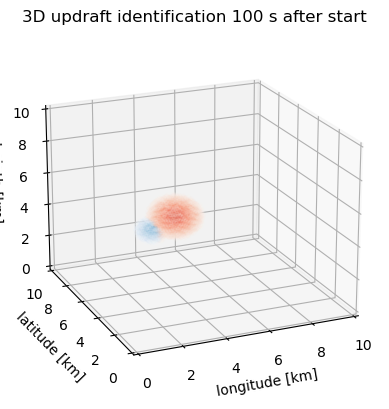

In [11]:



sPlotName = str(tt).zfill(3)+'_3D-idealized-cores.jpg'

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['Reds', 'Blues']
for dr in [1,2]:
    draft_act = np.array(np.where(labels == dr))
    
    for ii in range(draft_act.shape[1])[::3]:
        xs = draft_act[0,ii]/10
        ys = draft_act[1,ii]/10
        zs = draft_act[2,ii]/10
        speed = data_act[draft_act[0,ii], draft_act[1,ii], draft_act[2,ii]]
        ax.scatter(xs, ys, zs, marker='.', c = speed, cmap=colors[color_rank[dr-1]], alpha=0.1,
                  vmin = 3, vmax=20)

ax.set_xlabel('longitude [km]')
ax.set_ylabel('latitude [km]')
ax.set_zlabel('heigth [km]')

ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.set_zlim([0,10])


elev = 20
azim = angle_moove[tt]
roll = 0
ax.view_init(elev, azim, roll)

plt.title('3D updraft identification '+str(tt)+' s after start')

fig.savefig(sPlotFile+sPlotName, dpi=200)


In [12]:
sPlotFile+sPlotName

'/glade/campaign/mmm/c3we/prein/Papers/2023_ConvCores/plot/3D_idealized-cores/100_3D-idealized-cores.jpg'

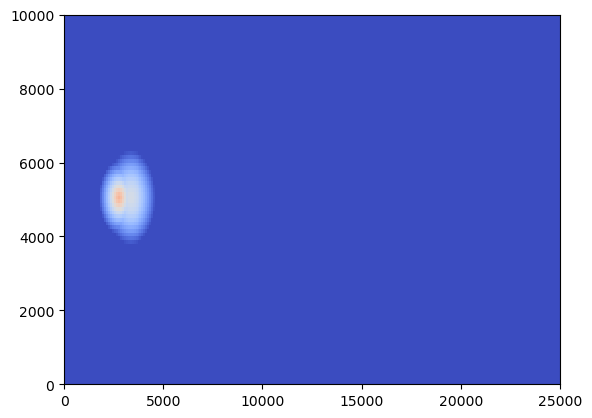

In [13]:
plt.pcolormesh(lon_m, lat_m, data[50,20,:,:], vmin=0, vmax=20, cmap='coolwarm')

In [14]:
height_lev = 50 # level
intersect = np.where(np.sum(data[:,height_lev,:,:]>0, axis=0)>0)

core_timeheight = {}
for loc in tqdm(range(len(intersect[0]))):
    la = intersect[0][loc]
    lo = intersect[1][loc]

    rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1
    draft_th = 10
    updrafts = data[:,:,la,lo].T > draft_th
    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
    # sort the objects according to their size
    Objects=ndimage.find_objects(rgiObjectsUD)

    cloudmask = np.copy(updrafts); cloudmask[:] = 1

    # core properties according to time-heigt observations
    core_timeheight[str(loc).zfill(3)] = core_2d_properties(Objects,
                      data[:,:,la,lo].T,
                      cloudmask,
                      height,
                      length)

100%|██████████| 1587/1587 [00:02<00:00, 597.83it/s]


In [15]:
rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1
draft_th = 10
tt = 200 # time steps after start
max_h = int(np.argmax(np.sum(data[tt,:,:,:], axis = (1,2))))
intersect = np.where(data[tt,max_h,:,:] > 0)

core_latlonheight = {}
for loc in tqdm(range(len(intersect[0]))):
    la = intersect[0][loc]
    lo = intersect[1][loc]

    updrafts = data[tt,:,la,:].T   > draft_th
    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
    # sort the objects according to their size
    Objects=ndimage.find_objects(rgiObjectsUD)

    cloudmask = np.copy(updrafts); cloudmask[:] = 1

    # core properties according to lon, height time slize
    core_latlonheight[str(loc).zfill(3)] = core_2d_properties(Objects,
                          data[tt,:,la,:].T,
                          cloudmask,
                          height,
                          lon_m)

100%|██████████| 697/697 [00:00<00:00, 1342.60it/s]


In [16]:
#  WORK ON 3D CORES
tt = 202

updrafts = data[tt,:,:,:] >1
rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)

w_3D = np.copy(updrafts[:,:,:])
# w_3D[np.isnan(cloudmask_3d)] = np.nan
rgiObjectsUD = rgiObjectsUD.astype(float)
# rgiObjectsUD[np.isnan(cloudmask_3d)] = np.nan

cores_3d = core_3d_properties(w_3D,
                  rgiObjectsUD,
                  Objects,
                  height,
                  lat_m,
                  lon_m)

In [17]:
cores_3d

{'1': {'mean elevation': 5600.0,
  'mean depth': 1701.6091954022988,
  'max depth': 3900.0,
  'mean speed': 1.0,
  'max speed': True,
  'mean width': array([300., 500., 500., ..., 500., 500., 300.]),
  'max width': 2900.0}}

In [18]:
# gr_core_act['mean elevation'] = mean_height
# gr_core_act['mean depth'] = core_height_mean
# gr_core_act['max depth'] = core_heigth_max
# gr_core_act['mean speed'] = core_speed_mean
# gr_core_act['max speed'] = core_speed_max
# gr_core_act['mean width'] = core_with_mean
# gr_core_act['max width'] = core_with_max
# gr_core_act['slope from vertical'] = core_slope

stat = 'mean width'
th = '1' # [1.5,3.0,6.0,10.0]
cores_2d = core_latlonheight
cores_vp = core_timeheight
# cores_3d = cores_3d_up



mean_width_2d = np.array( [
                            [
                                cores_2d[ii][jj][stat]
                                for jj in cores_2d[ii].keys()
                            ]
                            for ii in [s for s in list(cores_2d.keys()) if th in s]
                        ])
mean_width_2d = np.array([item for sublist in mean_width_2d for item in sublist])

mean_width_vp = np.array( [
                            [
                                cores_vp[ii][jj][stat]
                                for jj in cores_vp[ii].keys()
                            ]
                            for ii in [s for s in list(cores_vp.keys()) if th in s]
                        ])
mean_width_vp = np.array([item for sublist in mean_width_vp for item in sublist])

# mean_width_3d = np.array( [
#                             [
#                                 cores_3d[ii][jj][stat]
#                                 for jj in cores_3d[ii].keys()
#                             ]
#                             for ii in [s for s in list(cores_3d.keys()) if th in s]
#                         ])
# mean_width_3d = np.array([item for sublist in mean_width_3d for item in sublist])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

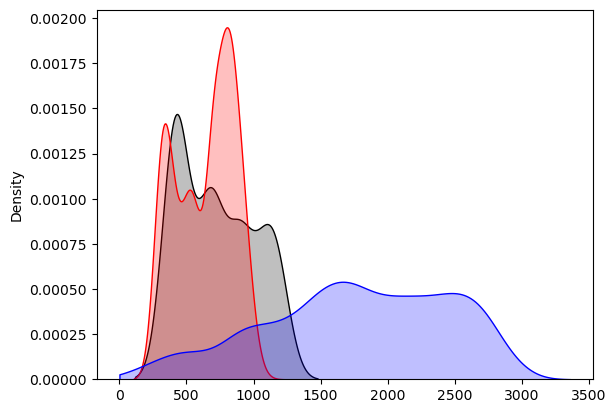

In [19]:
import seaborn as sns
fig = sns.kdeplot(mean_width_2d, shade=True, color="k", clip=[0, 100000], label='cross-section')
fig = sns.kdeplot(mean_width_vp, shade=True, color="r", clip=[0, 100000], label = 'time-height')
fig = sns.kdeplot(cores_3d['1'][stat], shade=True, color="b", clip=[0, 100000], label = '3D slize')
# fig = sns.kdeplot(mean_width_3d, shade=True, color="b", clip=[0, 100000])

plt.axvline(x=((np.pi*radius)/2), c='k', label='theoretical average width 2D')
# plt.axvline(x=cores_3d['1'][stat], c='b', label='3D core')


plt.legend()

plt.show()

In [ ]:
np.median(cores_3d['1'][stat])

In [ ]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy import ndimage

# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.logical_or(mask_circle1, mask_circle2)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

In [ ]:
np.mean(np.nansum(core_dx[:,:,10], axis=1))

In [ ]:
plt.pcolormesh(updrafts[49,:,:])

In [ ]:
stop()

In [ ]:
# def core_3d_properties(w_3D,
#                       rgiObjectsUD,
#                       Objects,
#                       height,
#                       lat_m,
#                       lon_m):

dx = lon_m[1:] - lon_m[:-1]
dx = np.append(dx, dx[-1])
dy = lat_m[1:] - lat_m[:-1]
dy = np.append(dy, dy[-1])
dxy = np.meshgrid(dx,dy)[0]

dx_3d = np.repeat(dxy[np.newaxis, :, :], len(height), axis=0)

dz = height[1:] - height[:-1]
dz = np.append(dz, dz[-1])
dz_3d = np.repeat(dz[:,np.newaxis], len(lat_m), axis=1)
dz_3d = np.repeat(dz_3d[:,:,np.newaxis], len(lon_m), axis=2)

gr_core = {}
for ob in range(len(Objects)):
    gr_core_act = {}

    heigt_core = Objects[ob][0].stop - Objects[ob][0].start
    if heigt_core <= 3:
        # cores that are less than four grid cell deep are not assessed
        continue

    core_ouline_act = rgiObjectsUD[Objects[ob]] == (ob+1)
    # plt.pcolormesh(core_ouline_act[10,:,:])

    core_dx = dx_3d[Objects[ob]] * core_ouline_act
    core_dx[core_dx == 0] = np.nan
    width_x = np.nansum(core_dx, axis=1); width_x[width_x == 0] = np.nan
    width_y = np.nansum(core_dx, axis=2); width_y[width_y == 0] = np.nan
    core_mean_width = np.append(width_x, width_y)
    core_max_width = np.nanmax([np.nanmax(np.nansum(core_dx, axis=1)) , np.nanmax(np.nansum(core_dx, axis=2))])

    area_profile = np.nancumsum(np.nansum(core_dx, axis=(1,2)))
    try:
        center_point = np.where(area_profile/np.nanmax(area_profile) > 0.5)[0][0]
    except:
        continue
    core_mean_elevation = height[Objects[ob][0]][center_point]

    core_dz = dz_3d[Objects[ob]] * core_ouline_act
    core_dz[core_dz == 0] = np.nan
    core_mean_depth = np.nanmean(np.nansum(core_dz, axis = 0))
    core_max_depth = np.nanmax(np.nansum(core_dz, axis = 0))

    core_w_act = np.copy(w_3D[Objects[ob]]) * core_ouline_act
    core_w_act[core_w_act == 0] = np.nan
    core_w_act[rgiObjectsUD[Objects[ob]] != (ob+1)] = np.nan
    core_mean_speed = np.nanmean(core_w_act)
    core_max_speed = np.nanmax(core_w_act)

    gr_core_act['mean elevation'] = core_mean_elevation
    gr_core_act['mean depth'] = core_mean_depth
    gr_core_act['max depth'] = core_max_depth
    gr_core_act['mean speed'] = core_mean_speed
    gr_core_act['max speed'] = core_max_speed
    gr_core_act['mean width'] = core_mean_width
    gr_core_act['max width'] = core_max_width

    gr_core[str(ob+1)] = gr_core_act
        


In [ ]:
gr_core

In [ ]:
core_mean_width

In [ ]:
stop()

In [ ]:
grDATA = {}
for dx in range(len(DX)):
    vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX[dx] + '/'+ SIM_All[si]+ '_'+ DX[dx] +'_Loc01.nc'
    ncfile = Dataset(vwp_file)
    height = np.squeeze(ncfile.variables["Height"])
    time = np.squeeze(ncfile.variables['Time'])
    ncfile.close()
    
    # from datetime import timedelta
    from datetime import datetime, timedelta
    StartDay = datetime(int(SIM[4:8]), int(SIM[8:10]), int(SIM[10:12]), int(SIM[13:15])) - timedelta(hours=6)
    StopDay = StartDay  + timedelta(hours=12)
    rgdTimeMCS = pd.date_range(StartDay, end=StopDay, freq=str(DT[dx])+'s') #'500ms')
    rgdTimeMCS = rgdTimeMCS[:len(time)]

    DATA = np.zeros((len(time),len(height), 20, len(VARS))); DATA[:] = np.nan
    lat_vs = np.zeros((20)); lat_vs[:] = np.nan
    lon_vs = np.copy(lat_vs)

    for lo in tqdm(range(20)):  
        loc = str(lo+1).zfill(2)
        vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX[dx] + '/'+ SIM_All[si]+ '_'+ DX[dx] +'_Loc' + loc + '.nc'
        ncfile = Dataset(vwp_file)
        
        lat_vs[lo] = ncfile.getncattr('profiler latitude')
        lon_vs[lo] = ncfile.getncattr('profiler longitude')
        for va in range(len(VARS)):
            # print('    '+VARS[va])
            DATA[:,:,lo,va] = np.squeeze(ncfile.variables[VARS[va]])
        grDATA[DX[dx]] = DATA

In [ ]:
np.where(np.max(DATA[:,:,:,0]) == DATA[:,:,:,0])

In [ ]:
rgdTimeMCS[6918]

In [ ]:
rgdTimeMCS.shape

In [ ]:
t0 = 0
t1 = 42000
loc = 8
plt.pcolormesh(rgdTimeMCS[t0:t1], height, DATA[t0:t1,:,loc,0].T, vmin=-25, vmax=25, cmap='coolwarm')

In [ ]:
plt.pcolormesh(rgdTimeMCS[t0:t1], height, DATA[t0:t1,:,11,0].T, vmin=-25, vmax=25, cmap='coolwarm')

### Read in dBZ at 20th model leve

In [ ]:
wrfout_files = np.sort(glob.glob(wrfout_dir+DX[dx]+'/Thomson_YSU/'+SIM+DX[dx]+'/wrfout_d02*'))
ncfile = Dataset(wrfout_files[0])
lat = np.squeeze(ncfile.variables["XLAT"])
lon = np.squeeze(ncfile.variables['XLONG'])
ncfile.close()

In [ ]:
dbz = np.zeros((len(wrfout_files), lat.shape[0], lat.shape[1])); dbz[:] = np.nan
for tt in tqdm(range(len(wrfout_files))):
    ncfile = Dataset(wrfout_files[tt])
    dbz[tt,:,:] = np.squeeze(ncfile.variables["REFL_10CM"][0,20,:,:])
    ncfile.close()

In [ ]:
# create time vector for wrfout files
import wrf
ncfile = Dataset(wrfout_files[0])
start_wrfout = wrf.extract_times(ncfile,0)
ncfile = Dataset(wrfout_files[-1])
stop_wrfout = wrf.extract_times(ncfile,0)

time_wrfout = pd.date_range(start_wrfout, end=stop_wrfout, freq='10min') #'500ms')

### Track high-reflectivity areas and determine their speed

In [ ]:
idbz_threshold = 40
MinObjVolume = 4000000 # m2
iSmooth = 16000
rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1

iSmoothGC=int(iSmooth/dx_m[dx])
dbz_smooth=scipy.ndimage.uniform_filter(dbz[:,:,:],[1,iSmoothGC,iSmoothGC])

# threshold the dbz
rgiTH_dbz=(dbz_smooth >= idbz_threshold)
rgrdbz_thresholded=np.copy(dbz)
rgrdbz_thresholded[rgiTH_dbz == False]=0
rgiObjectsUD, nr_objectsUD = ndimage.label(rgiTH_dbz,structure=rgiObj_Struct)

# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)
rgiVolObj=np.array([np.sum(rgiObjectsUD[Objects[ob]] == ob+1) for ob in range(nr_objectsUD)])
rgiObBySize=np.array([np.where(np.sort(rgiVolObj)[::-1][ob] == rgiVolObj)[0][0] for ob in range(nr_objectsUD)])
rgiObBySize=rgiObBySize[rgiVolObj[rgiObBySize] >= MinObjVolume]

# create final object array
dbz_objects=np.copy(rgiObjectsUD); dbz_objects[:]=0
for ob in range(len(rgiObBySize)):
    dbz_objects[rgiObjectsUD == (rgiObBySize[ob]+1)] = ob+1
    


In [ ]:
print('        break up long living cores')
from Tracking_Functions import BreakupObjects
MS_objects, object_split = BreakupObjects(dbz_objects,
                            3/6.,
                            1/6.)

In [ ]:
from Tracking_Functions import calc_grid_distance_area
from Tracking_Functions import calc_object_characteristics
_,_,Area,Gridspacing = calc_grid_distance_area(lon,lat)

cell_obj_characteristics = calc_object_characteristics(MS_objects.astype('int'), # feature object file
                                     dbz,         # original file used for feature detection
                                     'tmp/cell_stats.pkl',
                                     rgdTimeMCS,            # timesteps of the data
                                     lat,             # 2D latidudes
                                     lon,             # 2D Longitudes
                                     Gridspacing,
                                     Area,
                                     min_tsteps=3,
                                     split_merge = 0)

In [ ]:
# get cores that intersect with virtual sounding locations

# get location of vs in grid
from Tracking_Functions import radialdistance
lat_vs_id = np.copy(lat_vs); lat_vs_id[:] = np.nan
lon_vs_id = np.copy(lat_vs_id)
for ii in tqdm(range(len(lat_vs))):
    mindist = radialdistance(lat,lon,lat_vs[ii],lon_vs[ii])
    min_loc = np.argwhere(mindist == np.min(mindist))[0]
    lat_vs_id[ii] = min_loc[0]
    lon_vs_id[ii] = min_loc[1]

lat_vs_id = lat_vs_id.astype('int')
lon_vs_id = lon_vs_id.astype('int')

In [ ]:
dist = 60000 # m -- distance to extract arround the station
timewindow = 40 # minutes arround 2D obs
dx_dist = int(dist/dx_m[dx])

cores_vp_up = {}
cores_2d_up = {}
cores_3d_up = {}
cores_vp_down = {}
cores_2d_down = {}
cores_3d_down = {}

ud_min = 1.5
dd_min = 1.5
draft_th = [1.5,3.0,6.0,10.0]

direction = ['up', 'down']  # [ up - updraft; down - downdraft]
                
for ii in tqdm(range(len(lat_vs))):
    conv_inters = np.unique(MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])[1:]
    la_start = lat_vs_id[ii] - dx_dist
    la_stop = lat_vs_id[ii] + dx_dist + 1
    lo_start = lon_vs_id[ii] - dx_dist
    lo_stop = lon_vs_id[ii] + dx_dist +1

    location = 'loc-'+str(ii).zfill(2)

    # virtual profiler data
    data_vp = grDATA[DX[dx]][:,:,ii,:]

    for ca in range(len(conv_inters)):
        conv_element = 'conv-'+str(ca).zfill(3)
        files_int = wrfout_files[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        speed_ca_median = np.median(cell_obj_characteristics[str(conv_inters[ca])]['speed'])

        for fi in [0]: #range(len(files_int)):
            file_act = 'output-'+str(fi).zfill(2)
            ncfile = Dataset(files_int[fi])
            dbz_ca = np.squeeze(ncfile.variables["REFL_10CM"][0,:,la_start:la_stop,lo_start:lo_stop])
            w_ca = np.squeeze(ncfile.variables["W"][0,:,la_start:la_stop,lo_start:lo_stop])
            z_ca_stag = (np.squeeze(ncfile.variables["PHB"][0,:,la_start:la_stop,lo_start:lo_stop]) + \
                    np.squeeze(ncfile.variables["PH"][0,:,la_start:la_stop,lo_start:lo_stop])) / 9.81 - \
                    np.squeeze(ncfile.variables["HGT"][0,la_start:la_stop,lo_start:lo_stop])
            z_ca = (z_ca_stag[1:,:] + z_ca_stag[:-1,:])/2
            # brind 3D data to common grid
            dbz_ca_comz = wrf.interpz3d(dbz_ca, z_ca, height, missing = np.nan)
            w_ca_comz = wrf.interpz3d(w_ca, z_ca_stag, height, missing = np.nan)
            ncfile.close()

            # degrees to meters
            lon_m = np.linspace(0,Gridspacing*w_ca.shape[1], w_ca.shape[1]); lon_m = lon_m - np.mean(lon_m)
            lat_m = np.copy(lon_m)

            cloudmask = np.copy(dbz_ca_comz[:,dx_dist,:]); cloudmask[:] = 1
            cloudmask[0,:] = np.nan
            cloudmask[-1,:] = np.nan
            cloudmask[dbz_ca_comz[:,dx_dist,:] <= -30] = np.nan
            
            cloudmask_3d = np.copy(dbz_ca_comz[:,:,:]); cloudmask_3d[:] = 1
            cloudmask_3d[dbz_ca_comz[:,:,:] <= -30] = np.nan


#             plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 5, colors = 'r')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -5, colors = 'b')
#             plt.contour(lon_m/1000., height, 
#                            cloudmask > 0,
#                         colors='k')
#             plt.show()
            
#             stop()

            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                for th in range(len(draft_th)):
                    # virtual profiler draft characteristics
                    updrafts = w_ca_comz[:,dx_dist,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)

                    w_2D = np.copy(w_ca_comz[:,dx_dist,:]) * dire_sign
                    if direction[di] == 'up':
                        cores_2d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)
                    elif direction[di] == 'down':
                        cores_2d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)

                        
                    #  WORK ON 3D CORES
                    updrafts = w_ca_comz[:,:,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)

                    w_3D = np.copy(w_ca_comz[:,:,:]) * dire_sign
                    w_3D[np.isnan(cloudmask_3d)] = np.nan
                    rgiObjectsUD = rgiObjectsUD.astype(float)
                    rgiObjectsUD[np.isnan(cloudmask_3d)] = np.nan

                    if direction[di] == 'up':
                        cores_3d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)
                    elif direction[di] == 'down':
                        cores_3d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)

                    
                        
        # ---------------------------------------------
        # calculate properties from virtual profiler
        time_ca = time_wrfout[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        time_vp = (rgdTimeMCS <= (time_ca + timedelta(minutes=timewindow))[0]) & (rgdTimeMCS >= (time_ca - timedelta(minutes=timewindow))[0])  
        time_to_length = range(0,sum(time_vp), DT[dx]) * speed_ca_median

        wrf_dbz_column = wrf.dbz(data_vp[time_vp,:,VARS.index('P')][None,:], 
                        data_vp[time_vp,:,VARS.index('TK')][None,:], 
                        data_vp[time_vp,:,VARS.index('QV')][None,:], 
                        data_vp[time_vp,:,VARS.index('QR')][None,:], 
                        qs=data_vp[time_vp,:,VARS.index('QS')][None,:], 
                        qg=data_vp[time_vp,:,VARS.index('QG')][None,:],
                        use_varint = True,
                        use_liqskin=True)

        cloudmask = np.copy(DATA[time_vp,:,ii,VARS.index('WW')]); cloudmask[:] = 1
        cloudmask[0,:] = np.nan
        cloudmask[-1,:] = np.nan
        cloudmask[wrf_dbz_column[0] <= -30] = np.nan

        # plt.pcolormesh(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T, vmin=-25, vmax=25, cmap='coolwarm')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T > draft_min, colors = 'r')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T < -draft_min, colors = 'b')
        # plt.contour(time_to_length/1000., height, 
        #                cloudmask[:,:].T > 0, 
        #             colors='k')
        # plt.show()

        for th in range(len(draft_th)):
            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                # virtual profiler draft characteristics
                updrafts = data_vp[time_vp,:,VARS.index('WW')].T * dire_sign > draft_th[th]
                rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
                # sort the objects according to their size
                Objects=ndimage.find_objects(rgiObjectsUD)

                w_2D = np.copy(data_vp[time_vp,:,VARS.index('WW')].T)* dire_sign
                if direction[di] == 'up':
                    cores_vp_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  w_2D,
                                  cloudmask.T,
                                  height,
                                  time_to_length)
                elif direction[di] == 'down':
                    cores_vp_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  w_2D,
                                  cloudmask.T,
                                  height,
                                  time_to_length)
                    

                    

In [ ]:
plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 3, colors = 'r')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -3, colors = 'b')
# plt.contour(lon_m/1000., height, 
#                cloudmask > 0,
#             colors='k')
plt.axhline(y=height[40], color='k', linestyle='-')

In [ ]:
hh = 30
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] > 3, colors = 'r')
plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] < -3, colors = 'b')
plt.axhline(y=0, color='k', linestyle='-')

In [ ]:
dx_dist

In [ ]:
dxx = lon_m[1:] - lon_m[:-1]
dxx = np.append(dxx, dxx[-1])
dy = lat_m[1:] - lat_m[:-1]
dy = np.append(dy, dy[-1])
dxy = np.meshgrid(dxx,dy)[0]

dx_3d = np.repeat(dxy[np.newaxis, :, :], len(height), axis=0)

dz = height[1:] - height[:-1]
dz = np.append(dz, dz[-1])
dz_3d = np.repeat(dz[:,np.newaxis], len(lat_m), axis=1)
dz_3d = np.repeat(dz_3d[:,:,np.newaxis], len(lon_m), axis=2)

gr_core = {}
for ob in range(len(Objects)):
    gr_core_act = {}

    heigt_core = Objects[ob][0].stop - Objects[ob][0].start
    if heigt_core <= 3:
        # cores that are only one grid cell deep are not assessed
        continue

    core_ouline_act = rgiObjectsUD[Objects[ob]] == (ob+1)
    # plt.pcolormesh(core_ouline_act[10,:,:])

    core_dx = dx_3d[Objects[ob]] * core_ouline_act
    core_dx[core_dx == 0] = np.nan
    core_mean_width = np.nanmean(np.nansum(core_dx, axis=1)) + np.nanmean(np.nansum(core_dx, axis=2))
    core_max_width = np.nanmax([np.nanmax(np.nansum(core_dx, axis=1)) , np.nanmax(np.nansum(core_dx, axis=2))])
    stop()
    
    area_profile = np.nancumsum(np.nansum(core_dx, axis=(1,2)))
    try:
        center_point = np.where(area_profile/np.nanmax(area_profile) >= 0.5)[0][0]
    except:
        continue
    core_mean_elevation = height[Objects[ob][0]][center_point]

    core_dz = dz_3d[Objects[ob]] * core_ouline_act
    core_mean_depth = np.nanmean(np.nansum(core_dz, axis = 0))
    core_max_depth = np.nanmax(np.nansum(core_dz, axis = 0))

    core_w_act = np.copy(w_3D[Objects[ob]])
    core_w_act[rgiObjectsUD[Objects[ob]] != (ob+1)] = np.nan
    core_mean_speed = np.nanmean(core_w_act)
    core_max_speed = np.nanmax(core_w_act)

    gr_core_act['mean elevation'] = core_mean_elevation
    gr_core_act['mean depth'] = core_mean_depth
    gr_core_act['max depth'] = core_max_depth
    gr_core_act['mean speed'] = core_mean_speed
    gr_core_act['max speed'] = core_max_speed
    gr_core_act['mean width'] = core_mean_width
    gr_core_act['max width'] = core_max_width

    gr_core[str(ob+1)] = gr_core_act

In [ ]:
core_mean_width

In [ ]:
np.nanmean(np.nansum(core_dx, axis=1)) + np.nanmean(np.nansum(core_dx, axis=2))

In [ ]:
np.nansum(core_dx, axis=1).shape

In [ ]:
core_ouline_act

In [ ]:
# # 3D core properties
# th = 3
# updrafts = w_ca_comz[:,:,:]  * dire_sign > 3 #draft_th[th]
# rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
# # sort the objects according to their size
# Objects=ndimage.find_objects(rgiObjectsUD)

# w_3D = np.copy(w_ca_comz[:,:,:])* dire_sign
# if direction[di] == 'up':
#     cores_3d_up = core_3d_properties(w_3D,
#                       rgiObjectsUD,
#                       Objects,
#                       height,
#                       lat_m,
#                       lon_m)
# elif direction[di] == 'down':
#     cores_3d_down = core_3d_properties(w_3D,
#                       rgiObjectsUD,
#                       Objects,
#                       height,
#                       lat_m,
#                       lon_m)


In [ ]:
# cores_vp[location+'_'+conv_element] = core_2d_properties(Objects,
#                           w_2D,
#                           cloudmask.T,
#                           height,
#                           time_to_length)

In [ ]:
# gr_core_act['mean elevation'] = mean_height
# gr_core_act['mean depth'] = core_height_mean
# gr_core_act['max depth'] = core_heigth_max
# gr_core_act['mean speed'] = core_speed_mean
# gr_core_act['max speed'] = core_speed_max
# gr_core_act['mean width'] = core_with_mean
# gr_core_act['max width'] = core_with_max
# gr_core_act['slope from vertical'] = core_slope

stat = 'mean width'
th = '10.0' # [1.5,3.0,6.0,10.0]
cores_2d = cores_2d_up
cores_vp = cores_vp_up
cores_3d = cores_3d_up



mean_width_2d = np.array( [
                            [
                                cores_2d[ii][jj][stat]
                                for jj in cores_2d[ii].keys()
                            ]
                            for ii in [s for s in list(cores_2d.keys()) if th in s]
                        ])
mean_width_2d = np.array([item for sublist in mean_width_2d for item in sublist])

mean_width_vp = np.array( [
                            [
                                cores_vp[ii][jj][stat]
                                for jj in cores_vp[ii].keys()
                            ]
                            for ii in [s for s in list(cores_vp.keys()) if th in s]
                        ])
mean_width_vp = np.array([item for sublist in mean_width_vp for item in sublist])

mean_width_3d = np.array( [
                            [
                                cores_3d[ii][jj][stat]
                                for jj in cores_3d[ii].keys()
                            ]
                            for ii in [s for s in list(cores_3d.keys()) if th in s]
                        ])
mean_width_3d = np.array([item for sublist in mean_width_3d for item in sublist])

In [ ]:
import seaborn as sns
fig = sns.kdeplot(mean_width_2d, shade=True, color="k", clip=[0, 100000])
fig = sns.kdeplot(mean_width_vp, shade=True, color="r", clip=[0, 100000])
fig = sns.kdeplot(mean_width_3d, shade=True, color="b", clip=[0, 100000])
plt.show()

In [ ]:
cores_3d

In [ ]:
mean_width_vp

In [ ]:
# virtual profiler draft characteristics
updrafts = DATA[time_vp,:,loc,VARS.index('WW')].T > 10
rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])

# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)
# rgiVolObj=np.array([np.sum(rgiObjectsUD[Objects[ob]] == ob+1) for ob in range(nr_objectsUD)])

In [ ]:

w_2D = np.copy(DATA[time_vp,:,loc,VARS.index('WW')].T)
gr_core = core_2d_properties(Objects,
                  w_2D,
                  cloudmask.T,
                  height,
                  time_to_length)

In [ ]:
gr_core

In [ ]:
plt.pcolormesh(lat_m / 1000., height,
               dbz_ca[:,dx_dist,:], vmin=0, vmax=60, cmap='coolwarm')
# plt.axvline(x=lon_vs_id[ii], c='k')

In [ ]:
plt.pcolormesh(lat_m / 1000., height,
               w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
# plt.axvline(x=lon_vs_id[ii], c='k')

In [ ]:
plt.pcolormesh(lat_m / 1000.,
               lon_m / 1000.,
               w_ca[35,:,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.plot(0, 0, 'ok')

In [ ]:
plt.pcolormesh(lat_m / 1000.,
               lon_m / 1000.,
               dbz_ca[35,:,:], vmin=0, vmax=60, cmap='coolwarm')
plt.plot(0, 0, 'ok')

In [ ]:
files_int[fi]

In [ ]:
plt.pcolormesh(lon,lat,dbz[10,:,:]>42, vmin=0, vmax=1, cmap = 'coolwarm')
for ii in tqdm(range(len(lat_vs))):
    plt.plot(lon_vs[ii], lat_vs[ii], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,dbz_smooth[15,:,:]>42, vmin=0, vmax=1, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,MS_objects[14,:,:], vmin=0, vmax=25, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,MS_objects[19,:,:], vmin=0, vmax=10, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')